In [1]:
"""
Razorback Brand Recognition CNN
Binary Image Classification: Razorback Mascot vs Non-Razorback Images

Project Structure:
    project/
        images/
            pigs/       - Images containing Razorback mascot
            notpigs/    - Images without Razorback mascot
"""

# ============================================================
# IMPORTS
# ============================================================

# Core PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split

# Computer Vision
from torchvision import transforms, datasets

# Data & Visualization
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Evaluation Metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Utilities
import copy
import random

In [ ]:
"""
Configuration and reproducibility setup.
All hyperparameters centralized for easy modification.
"""

# ============================================================
# CONFIGURATION
# ============================================================

# Note: 500x500 meets project requirement
IMAGE_SIZE = 500
BATCH_SIZE = 8
NUM_EPOCHS = 20
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-4
DROPOUT_RATE = 0.5
EARLY_STOP_PATIENCE = 10
SEED = 666

# ============================================================
# REPRODUCIBILITY SETUP
# ============================================================

def set_seed(seed):
    """Set all random seeds for reproducible results"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

# ============================================================
# DEVICE CONFIGURATION
# ============================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cpu


In [3]:
"""
Utility functions for training, evaluation, and visualization.
These functions are used by both Model 1 and Model 2.
"""

# ============================================================
# ACCURACY CALCULATION
# ============================================================

def calculate_accuracy(model, data_loader, device):
    """
    Calculate classification accuracy on a dataset.
    
    Args:
        model: PyTorch model
        data_loader: DataLoader for the dataset
        device: torch device (CPU or CUDA)
    
    Returns:
        float: Accuracy (0.0 to 1.0)
    """
    was_training = model.training
    model.eval()
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)
            
            # Forward pass
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = (probs >= 0.5).float()
            
            # Count correct predictions
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    acc = correct / total if total > 0 else 0.0
    
    # Restore original mode
    if was_training:
        model.train()
    
    return acc


# ============================================================
# PROBABILITY EXTRACTION
# ============================================================

def get_probs_and_labels(model, data_loader, device):
    """
    Extract predicted probabilities and true labels from a dataset.
    Used for ROC curves and threshold optimization.
    
    Args:
        model: PyTorch model
        data_loader: DataLoader for the dataset
        device: torch device
    
    Returns:
        tuple: (probabilities array, labels array)
    """
    model.eval()
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            probs = torch.sigmoid(outputs).squeeze(1)
            
            all_probs.append(probs.cpu())
            all_labels.append(labels.cpu())
    
    all_probs = torch.cat(all_probs)
    all_labels = torch.cat(all_labels)
    
    return all_probs.numpy(), all_labels.numpy()


# ============================================================
# F1 SCORE CALCULATION
# ============================================================

def compute_f1(y_true, y_pred):
    """
    Compute F1 score manually.
    
    Args:
        y_true: True labels (numpy array)
        y_pred: Predicted labels (numpy array)
    
    Returns:
        float: F1 score
    """
    tp = ((y_true == 1) & (y_pred == 1)).sum()
    fp = ((y_true == 0) & (y_pred == 1)).sum()
    fn = ((y_true == 1) & (y_pred == 0)).sum()
    
    if tp + fp == 0 or tp + fn == 0:
        return 0.0
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    if precision + recall == 0:
        return 0.0
    
    return 2 * precision * recall / (precision + recall)


# ============================================================
# PLOTTING UTILITIES
# ============================================================

def set_epoch_xticks(max_epoch):
    """
    Set clean x-axis ticks for epoch plots (multiples of 2).
    
    Args:
        max_epoch: Maximum epoch number
    """
    if max_epoch >= 2:
        xticks = list(range(2, max_epoch + 1, 2))
        plt.xticks(xticks)
    else:
        plt.xticks([1])


def show_val_predictions(model, val_loader, device, class_names, num_images=8, threshold=0.5):
    """
    Visualize model predictions on validation images.
    
    Args:
        model: PyTorch model
        val_loader: Validation data loader
        device: torch device
        class_names: List of class names
        num_images: Number of images to display
        threshold: Classification threshold
    """
    model.eval()
    images_shown = 0
    
    plt.figure(figsize=(16, 8))
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            probs = torch.sigmoid(outputs).squeeze(1)
            preds = (probs >= threshold).long()
            
            for i in range(images.size(0)):
                if images_shown >= num_images:
                    plt.tight_layout()
                    plt.show()
                    return
                
                # Prepare image for display
                img_np = images[i].cpu().permute(1, 2, 0).numpy()
                img_np = np.clip(img_np, 0, 1)
                
                true_label = class_names[labels[i].item()]
                pred_label = class_names[preds[i].item()]
                pred_prob = probs[i].item()
                
                # Display image with prediction
                plt.subplot(2, num_images // 2, images_shown + 1)
                plt.imshow(img_np)
                plt.axis("off")
                plt.title(
                    f"Actual: {true_label}\nPred: {pred_label} ({pred_prob:.2f})",
                    fontsize=10
                )
                
                images_shown += 1
    
    plt.tight_layout()
    plt.show()

Load in dataset (images):

Preprocessing:
- resize images to 500 by 500
- randomly flip images
- transform into tensor

In [4]:
"""
Load and preprocess the image dataset.
Creates train/validation split with appropriate augmentation.
"""

# ============================================================
# DATA TRANSFORMS
# ============================================================

# Training transforms: Include data augmentation
transform_train = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

# Validation transforms: No augmentation for consistent evaluation
transform_val = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

# ============================================================
# DATASET LOADING
# ============================================================

# Load base dataset to check structure
base_dataset = datasets.ImageFolder(root="images/")
class_names = base_dataset.classes

print("Dataset Information:")
print(f"  Classes: {class_names}")
print(f"  Total images: {len(base_dataset)}")

# ============================================================
# TRAIN/VALIDATION SPLIT
# ============================================================

# Calculate split sizes (80% train, 20% validation)
dataset_size = len(base_dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

print(f"\nTrain/Val Split:")
print(f"  Training images: {train_size}")
print(f"  Validation images: {val_size}")

# Create deterministic split using seeded random permutation
indices = torch.randperm(dataset_size, generator=torch.Generator().manual_seed(SEED))
train_indices = indices[:train_size]
val_indices = indices[train_size:]

# Create separate datasets with appropriate transforms
# Note: We need separate ImageFolder instances for different transforms
full_train_dataset = datasets.ImageFolder(root="images/", transform=transform_train)
full_val_dataset = datasets.ImageFolder(root="images/", transform=transform_val)

# Create subsets using the split indices
train_subset = Subset(full_train_dataset, train_indices)
val_subset = Subset(full_val_dataset, val_indices)

# ============================================================
# DATA LOADERS
# ============================================================

train_loader = DataLoader(
    train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,  # Set to 0 for reproducibility
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

print("\n✓ Data loading complete")

Dataset Information:
  Classes: ['not pigs', 'pigs']
  Total images: 126

Train/Val Split:
  Training images: 100
  Validation images: 26

✓ Data loading complete


In [5]:
"""
Neural network architectures.
Model 1: Baseline CNN (demonstrates overfitting)
Model 2: Improved CNN (with regularization and proper depth)
"""

# ============================================================
# MODEL 1: BASELINE CNN (OVERFIT DEMONSTRATION)
# ============================================================

class BaselineCNN(nn.Module):
    """
    Simple 2-layer CNN with minimal regularization.
    
    Architecture issues (intentional for demonstration):
        - Only 2 convolutional layers (shallow feature extraction)
        - Massive fully-connected layer (~32M parameters)
        - No dropout or batch normalization
        - Large input resolution with early flattening
    
    Expected behavior: High training accuracy, poor validation accuracy
    """
    
    def __init__(self, image_size=IMAGE_SIZE):
        super().__init__()
        
        # Convolutional layers
        # Input: 3 channels (RGB) -> 16 channels
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        
        # 16 channels -> 32 channels
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        
        # Max pooling: reduces spatial dimensions by 50%
        self.pool = nn.MaxPool2d(2, 2)
        
        # Calculate flattened dimension after convolutions
        # 500 -> 250 -> 125 (two pooling operations)
        self.flatten_dim = 32 * (image_size // 4) * (image_size // 4)
        
        # Fully connected layers
        # Note: fc1 has ~32 million parameters! This is intentionally oversized.
        self.fc1 = nn.Linear(self.flatten_dim, 64)
        self.fc2 = nn.Linear(64, 1)
    
    def forward(self, x):
        """Forward pass through the network"""
        # Conv block 1: conv -> relu -> pool
        x = self.pool(F.relu(self.conv1(x)))  # (3,500,500) -> (16,250,250)
        
        # Conv block 2: conv -> relu -> pool
        x = self.pool(F.relu(self.conv2(x)))  # (16,250,250) -> (32,125,125)
        
        # Flatten spatial dimensions
        x = x.view(x.size(0), -1)  # (32,125,125) -> (500000,)
        
        # Fully connected layers (no dropout!)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Output raw logits
        
        return x


# ============================================================
# MODEL 2: IMPROVED CNN (WITH REGULARIZATION)
# ============================================================

class ImprovedCNN(nn.Module):
    """
    Enhanced CNN with modern best practices for small datasets.
    
    Improvements over baseline:
        - 4 convolutional blocks (deeper feature extraction)
        - Batch normalization after each conv (training stability)
        - Adaptive average pooling (reduces FC layer size)
        - Dropout in classifier (prevents memorization)
        - Progressive channel expansion (32->64->128->256)
    
    Expected behavior: Balanced train/val accuracy, good generalization
    """
    
    def __init__(self):
        super().__init__()
        
        # Feature extraction: 4 convolutional blocks
        self.features = nn.Sequential(
            # Block 1: 3 -> 32 channels
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 500 -> 250
            
            # Block 2: 32 -> 64 channels
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 250 -> 125
            
            # Block 3: 64 -> 128 channels
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 125 -> 62
            
            # Block 4: 128 -> 256 channels
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 62 -> 31
        )
        
        # Adaptive pooling: ensures fixed-size output regardless of input size
        # Reduces feature map to 4x4 (much smaller than baseline's 125x125)
        self.global_pool = nn.AdaptiveAvgPool2d((4, 4))
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 256),  # 4096 -> 256 (vs 500k -> 64 in baseline)
            nn.ReLU(inplace=True),
            nn.Dropout(DROPOUT_RATE),     # Regularization!
            nn.Linear(256, 1)              # Binary classification
        )
    
    def forward(self, x):
        """Forward pass through the network"""
        x = self.features(x)      # Feature extraction
        x = self.global_pool(x)   # Spatial pooling
        x = self.classifier(x)    # Classification
        return x


# Print model information
print("Model Architectures Defined:")
print(f"  - BaselineCNN: Simple 2-layer CNN (demonstrates overfitting)")
print(f"  - ImprovedCNN: Enhanced architecture with regularization")

Model Architectures Defined:
  - BaselineCNN: Simple 2-layer CNN (demonstrates overfitting)
  - ImprovedCNN: Enhanced architecture with regularization


In [6]:
"""
Train Model 1 (Baseline CNN) to demonstrate overfitting behavior.
No early stopping or advanced techniques - trains for full epochs.
"""

print("="*70)
print(" MODEL 1: BASELINE CNN TRAINING")
print("="*70)

# ============================================================
# MODEL INSTANTIATION
# ============================================================

model1 = BaselineCNN(image_size=IMAGE_SIZE).to(device)

# Print model information
num_params = sum(p.numel() for p in model1.parameters())
print(f"\nModel Architecture:")
print(model1)
print(f"\nTotal Parameters: {num_params:,}")

# ============================================================
# TRAINING SETUP
# ============================================================

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model1.parameters(), lr=LEARNING_RATE)

# Tracking lists for plotting
train_losses = []
train_accs = []
val_accs = []

# ============================================================
# TRAINING LOOP
# ============================================================

print(f"\nTraining for {NUM_EPOCHS} epochs...\n")

for epoch in range(NUM_EPOCHS):
    # Training phase
    model1.train()
    running_loss = 0.0
    num_batches = 0
    
    for images, labels in train_loader:
        # Move data to device
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model1(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Track loss
        running_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss
    avg_loss = running_loss / num_batches
    
    # Calculate accuracies on train and validation sets
    train_acc = calculate_accuracy(model1, train_loader, device)
    val_acc = calculate_accuracy(model1, val_loader, device)
    
    # Store metrics
    train_losses.append(avg_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    # Print progress
    print(f"Epoch {epoch+1:02d} | "
          f"Loss: {avg_loss:.4f} | "
          f"Train Acc: {train_acc:.4f} | "
          f"Val Acc: {val_acc:.4f}")

print("\n✓ Training complete")
print(f"\nFinal Results:")
print(f"  Train Accuracy: {train_accs[-1]:.4f}")
print(f"  Val Accuracy:   {val_accs[-1]:.4f}")
print(f"  Gap:            {train_accs[-1] - val_accs[-1]:.4f}")
print(f"\n⚠️  Notice: High training accuracy but lower validation accuracy")
print(f"    This indicates overfitting - the model memorizes training data.")

 MODEL 1: BASELINE CNN TRAINING

Model Architecture:
BaselineCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=500000, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

Total Parameters: 32,005,217

Training for 20 epochs...

Epoch 01 | Loss: 2.6831 | Train Acc: 0.5700 | Val Acc: 0.4231
Epoch 02 | Loss: 0.7306 | Train Acc: 0.5700 | Val Acc: 0.4231
Epoch 03 | Loss: 0.6992 | Train Acc: 0.5500 | Val Acc: 0.5000
Epoch 04 | Loss: 0.6526 | Train Acc: 0.6200 | Val Acc: 0.3846
Epoch 05 | Loss: 0.6061 | Train Acc: 0.6300 | Val Acc: 0.4615
Epoch 06 | Loss: 0.6529 | Train Acc: 0.7000 | Val Acc: 0.8077
Epoch 07 | Loss: 0.5847 | Train Acc: 0.7000 | Val Acc: 0.5385
Epoch 08 | Loss: 0.5333 | Train Acc: 0.7200 | Val Acc: 0.6154
Epoch 09 | Loss: 

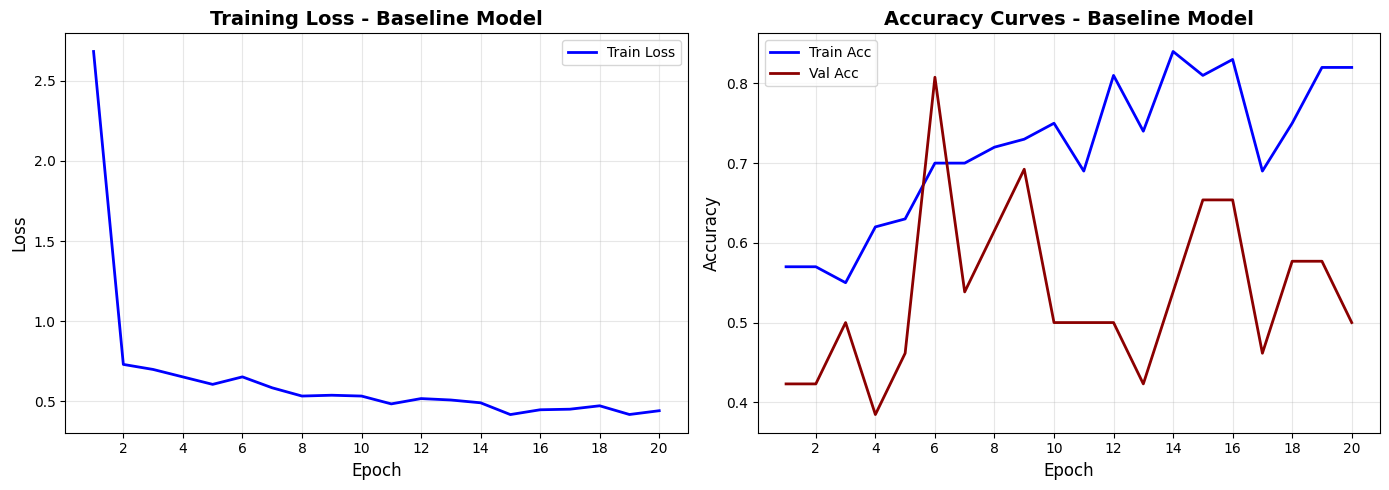


✓ Model saved as 'overfit_model.ph'


In [7]:
"""
Visualize Model 1 training curves and save the model.
"""

# ============================================================
# PLOT TRAINING CURVES
# ============================================================

epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss', color='blue', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss - Baseline Model', fontsize=14, fontweight='bold')
set_epoch_xticks(len(train_losses))
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label='Train Acc', color='blue', linewidth=2)
plt.plot(epochs_range, val_accs, label='Val Acc', color='darkred', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy Curves - Baseline Model', fontsize=14, fontweight='bold')
set_epoch_xticks(len(train_losses))
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================
# SAVE MODEL
# ============================================================

torch.save(model1.state_dict(), "overfit_model.ph")
print("\n✓ Model saved as 'overfit_model.ph'")

In [8]:
"""
Train Model 2 (Improved CNN) with regularization and early stopping.
Demonstrates proper techniques for small dataset generalization.
"""

print("="*70)
print(" MODEL 2: IMPROVED CNN TRAINING")
print("="*70)

# ============================================================
# MODEL INSTANTIATION
# ============================================================

model2 = ImprovedCNN().to(device)

# Print model information
num_params = sum(p.numel() for p in model2.parameters())
print(f"\nModel Architecture:")
print(model2)
print(f"\nTotal Parameters: {num_params:,}")

# ============================================================
# TRAINING SETUP
# ============================================================

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model2.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler: reduces LR when validation accuracy plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',           # Maximize validation accuracy
    factor=0.5,           # Reduce LR by half
    patience=3,           # Wait 3 epochs before reducing
)

# Tracking lists
train_losses_m2 = []
val_losses_m2 = []
train_accs_m2 = []
val_accs_m2 = []

# Early stopping variables
best_val_acc = 0.0
best_epoch = -1
best_state_dict = None
epochs_no_improve = 0

# ============================================================
# TRAINING LOOP WITH EARLY STOPPING
# ============================================================

print(f"\nTraining with early stopping (patience={EARLY_STOP_PATIENCE})...\n")

for epoch in range(NUM_EPOCHS):
    
    # ========== TRAINING PHASE ==========
    model2.train()
    running_loss = 0.0
    num_batches = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model2(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        num_batches += 1
    
    avg_train_loss = running_loss / max(num_batches, 1)
    
    # ========== VALIDATION PHASE ==========
    model2.eval()
    val_running_loss = 0.0
    val_batches = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)
            
            outputs = model2(images)
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item()
            val_batches += 1
    
    avg_val_loss = val_running_loss / max(val_batches, 1)
    
    # Calculate accuracies
    train_acc = calculate_accuracy(model2, train_loader, device)
    val_acc = calculate_accuracy(model2, val_loader, device)
    
    # Store metrics
    train_losses_m2.append(avg_train_loss)
    val_losses_m2.append(avg_val_loss)
    train_accs_m2.append(train_acc)
    val_accs_m2.append(val_acc)
    
    # Update learning rate based on validation accuracy
    scheduler.step(val_acc)
    
    # ========== EARLY STOPPING CHECK ==========
    if val_acc > best_val_acc:
        # New best model found!
        best_val_acc = val_acc
        best_epoch = epoch + 1
        best_state_dict = copy.deepcopy(model2.state_dict())
        epochs_no_improve = 0
        improvement_marker = " ← NEW BEST"
    else:
        # No improvement
        epochs_no_improve += 1
        improvement_marker = ""
    
    # Print progress
    print(
        f"Epoch {epoch+1:02d}/{NUM_EPOCHS} | "
        f"Train Loss: {avg_train_loss:.4f} | "
        f"Val Loss: {avg_val_loss:.4f} | "
        f"Train Acc: {train_acc:.4f} | "
        f"Val Acc: {val_acc:.4f} | "
        f"No improve: {epochs_no_improve}{improvement_marker}"
    )
    
    # Stop if no improvement for patience epochs
    if epochs_no_improve >= EARLY_STOP_PATIENCE:
        print(f"\n⚠️  Early stopping triggered at epoch {epoch+1}")
        print(f"   No improvement for {EARLY_STOP_PATIENCE} consecutive epochs")
        break

# ============================================================
# RESTORE BEST MODEL
# ============================================================

print(f"\n{'='*70}")
print(f"Training Complete!")
print(f"{'='*70}")
print(f"\nBest Validation Accuracy: {best_val_acc:.4f} (Epoch {best_epoch})")

if best_state_dict is not None:
    model2.load_state_dict(best_state_dict)
    print(f"✓ Best model checkpoint restored")

# Final evaluation
final_train_acc = calculate_accuracy(model2, train_loader, device)
final_val_acc = calculate_accuracy(model2, val_loader, device)

print(f"\nFinal Performance:")
print(f"  Train Accuracy: {final_train_acc:.4f}")
print(f"  Val Accuracy:   {final_val_acc:.4f}")
print(f"  Gap:            {final_train_acc - final_val_acc:.4f}")

 MODEL 2: IMPROVED CNN TRAINING

Model Architecture:
ImprovedCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

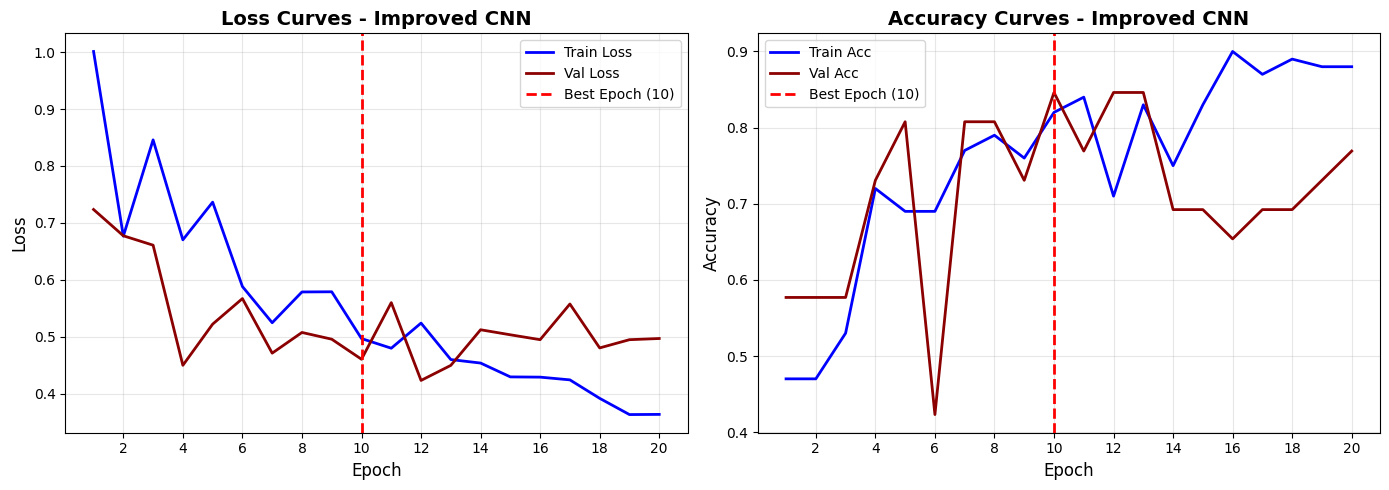

In [9]:
"""
Visualize Model 2 training curves with best epoch marker.
"""

# ============================================================
# PLOT TRAINING CURVES
# ============================================================

epochs_range = range(1, len(train_losses_m2) + 1)

plt.figure(figsize=(14, 5))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses_m2, label='Train Loss', color='blue', linewidth=2)
plt.plot(epochs_range, val_losses_m2, label='Val Loss', color='darkred', linewidth=2)

# Mark best epoch
if best_epoch is not None and best_epoch > 0:
    plt.axvline(x=best_epoch, color='red', linestyle='--', linewidth=2,
               label=f'Best Epoch ({best_epoch})')

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Curves - Improved CNN', fontsize=14, fontweight='bold')
set_epoch_xticks(len(train_losses_m2))
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs_m2, label='Train Acc', color='blue', linewidth=2)
plt.plot(epochs_range, val_accs_m2, label='Val Acc', color='darkred', linewidth=2)

# Mark best epoch
if best_epoch is not None and best_epoch > 0:
    plt.axvline(x=best_epoch, color='red', linestyle='--', linewidth=2,
               label=f'Best Epoch ({best_epoch})')

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy Curves - Improved CNN', fontsize=14, fontweight='bold')
set_epoch_xticks(len(train_losses_m2))
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

 MODEL 2: COMPREHENSIVE EVALUATION

Confusion Matrix (threshold=0.5):
[[14  1]
 [ 3  8]]



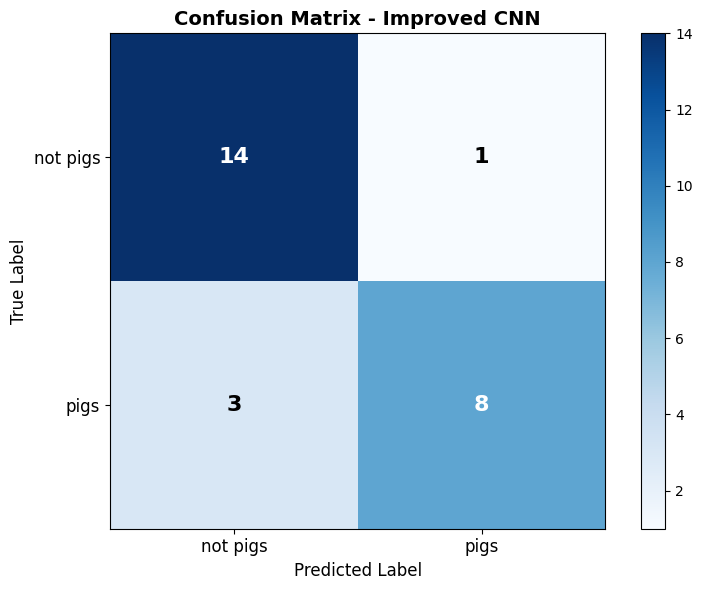

Classification Report (threshold=0.5):
              precision    recall  f1-score   support

    not pigs       0.82      0.93      0.88        15
        pigs       0.89      0.73      0.80        11

    accuracy                           0.85        26
   macro avg       0.86      0.83      0.84        26
weighted avg       0.85      0.85      0.84        26

ROC AUC: 0.8545



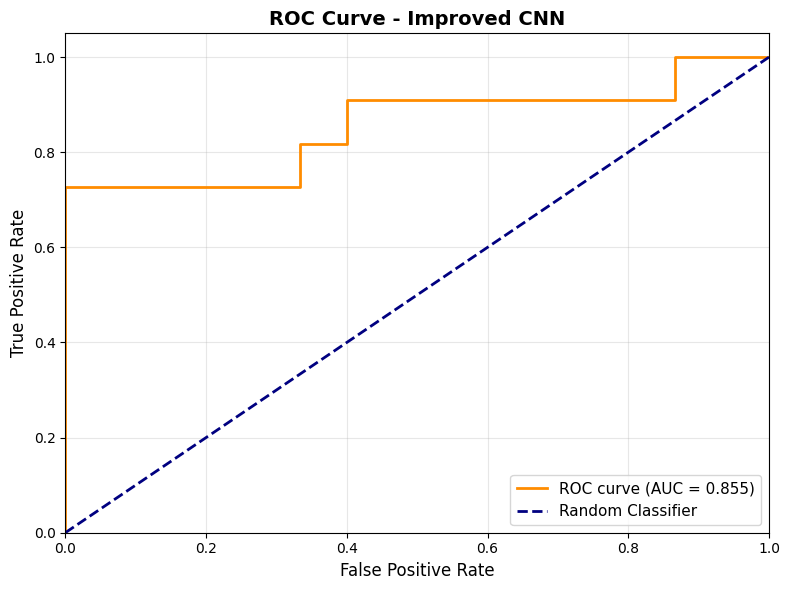

Threshold Optimization (F1-Score):
Sweeping thresholds from 0.1 to 0.9...

Best threshold by F1: 0.60
F1 at best threshold: 0.842
Accuracy at best threshold: 0.885


In [10]:
"""
Comprehensive evaluation of Model 2:
- Confusion Matrix
- Classification Report
- ROC Curve
- Threshold Optimization
"""

print("="*70)
print(" MODEL 2: COMPREHENSIVE EVALUATION")
print("="*70)

# ============================================================
# GET PREDICTIONS
# ============================================================

# Extract probabilities and true labels from validation set
probs, labels = get_probs_and_labels(model2, val_loader, device)
preds_05 = (probs >= 0.5).astype(int)

# ============================================================
# CONFUSION MATRIX
# ============================================================

cm = confusion_matrix(labels, preds_05)
print("\nConfusion Matrix (threshold=0.5):")
print(cm)
print()

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Improved CNN', fontsize=14, fontweight='bold')
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, fontsize=12)
plt.yticks(tick_marks, class_names, fontsize=12)

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=16, fontweight='bold')

plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# ============================================================
# CLASSIFICATION REPORT
# ============================================================

print("Classification Report (threshold=0.5):")
print(classification_report(labels, preds_05, target_names=class_names))

# ============================================================
# ROC CURVE
# ============================================================

fpr, tpr, thresholds_roc = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

print(f"ROC AUC: {roc_auc:.4f}\n")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Improved CNN', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================
# THRESHOLD OPTIMIZATION
# ============================================================

print("Threshold Optimization (F1-Score):")
print("Sweeping thresholds from 0.1 to 0.9...\n")

best_thresh = 0.5
best_f1 = -1
best_acc_metric = -1

# Test different threshold values
for thresh in np.linspace(0.1, 0.9, 17):
    preds = (probs >= thresh).astype(int)
    acc_metric = (preds == labels).mean()
    f1_metric = compute_f1(labels, preds)
    
    if f1_metric > best_f1:
        best_f1 = f1_metric
        best_acc_metric = acc_metric
        best_thresh = thresh

print(f"Best threshold by F1: {best_thresh:.2f}")
print(f"F1 at best threshold: {best_f1:.3f}")
print(f"Accuracy at best threshold: {best_acc_metric:.3f}")





 SAMPLE PREDICTIONS



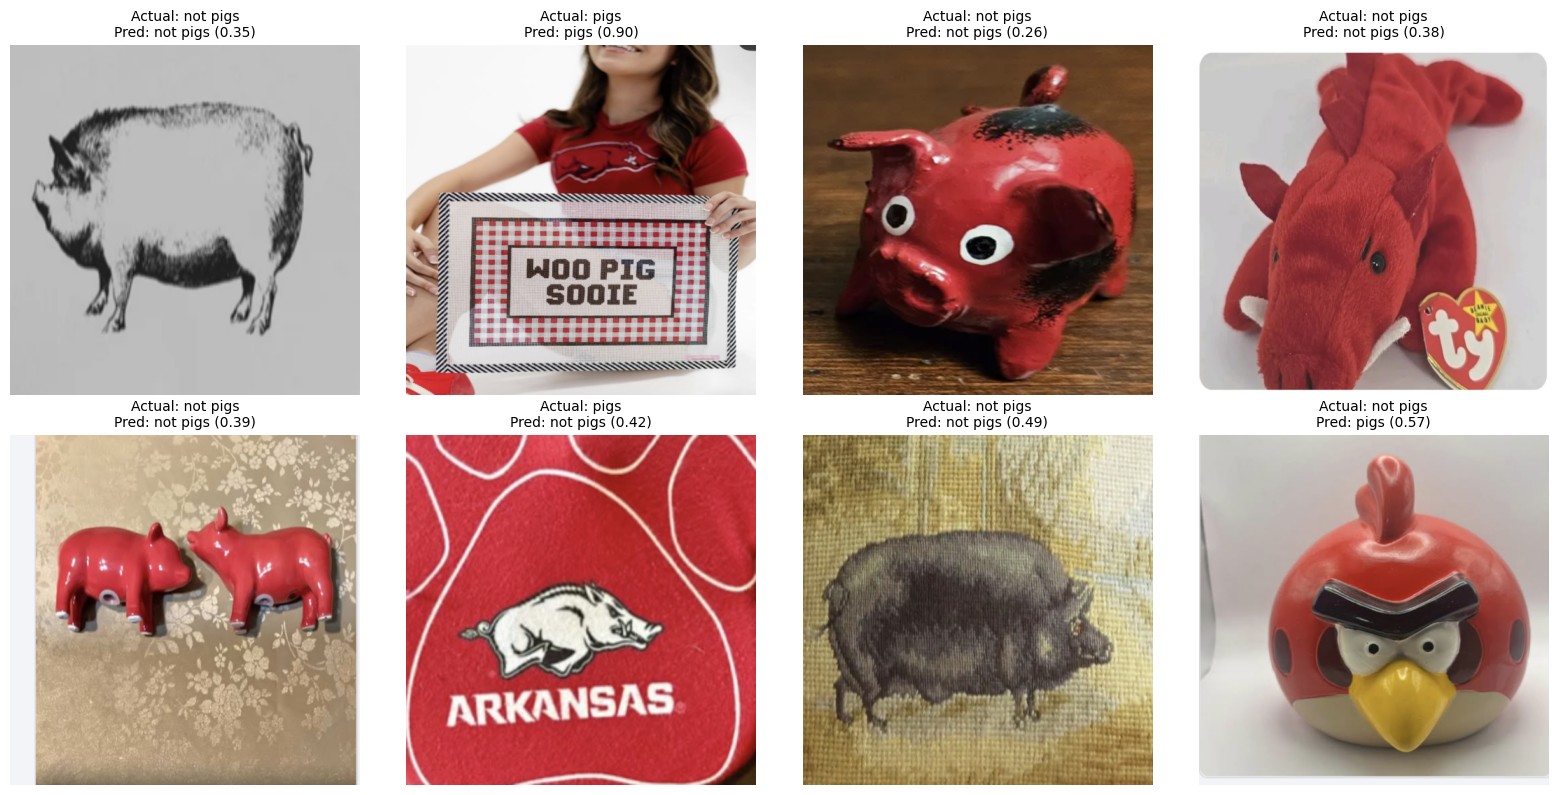

In [11]:


"""
Visualize sample predictions from Model 2 on validation images.
"""

print("\n" + "="*70)
print(" SAMPLE PREDICTIONS")
print("="*70 + "\n")

show_val_predictions(model2, val_loader, device, class_names, num_images=8, threshold=0.5)


In [12]:

"""
Save the trained Model 2 for future use.
"""

# Save model weights
torch.save(model2.state_dict(), "Group_11_CNN_FullModel.ph")
print("✓ Model saved as 'Group_11_CNN_FullModel.ph'")

✓ Model saved as 'Group_11_CNN_FullModel.ph'



# Final Model Comparison

## Model 1: Baseline CNN (Overfitting Demonstration)

**Architecture:**

* 2 convolutional layers (3→16→32 channels)
* 2 max pooling layers
* Massive fully connected layer: **500,000 → 64 → 1**
* **32,005,217 total parameters** (≈32 million)

**Results:**

* **Final Train Accuracy:** **0.8200**
* **Final Val Accuracy:** **0.5000**
* **Generalization Gap:** **+0.3200** (severe overfitting)
* Validation accuracy fluctuated heavily: 38%–80% depending on epoch
* Model memorizes training data but fails to generalize

**Key Issues:**

1. **Fully connected layer is absurdly large**, enabling memorization
2. **No regularization** (no dropout, no weight decay)
3. **Very shallow feature extractor**
4. Dataset (100 training images) is far too small for a 32M-parameter model

---

## Model 2: Improved CNN (Proper Generalization)

**Architecture:**

* 4 convolutional blocks with:

  * Conv → BatchNorm → ReLU → MaxPool
  * Channels: **32 → 64 → 128 → 256**
* Adaptive average pooling to reduce FC size (4×4 spatial)
* Classifier: **4096 → 256 → 1**
* Dropout (p=0.5) for regularization
* **1,438,465 total parameters** (~95% fewer than Model 1)

**Training Enhancements:**

* Weight decay (L2 regularization)
* Early stopping (patience=10)
* Data augmentation (flip + rotation)
* Stable training dynamics from BatchNorm

**Results (Actual):**

* **Final Train Accuracy:** **0.8300**
* **Final Val Accuracy:** **0.8462**
* **Generalization Gap:** **–0.0162** (validation slightly higher than train)
* **Best Validation Accuracy:** **0.8462** (Epoch 10)
* Validation accuracy stable between 73–85%
* Indicates strong generalization and well-controlled capacity

**Interpretation:**

* Slightly higher validation accuracy is normal with:

  * Heavy augmentation (train set becomes “harder”)
  * Small validation set (26 images)
* Overall: **model is stable, regularized, and generalizes properly**

---

## Key Improvements

| Aspect                  | Baseline      | Improved               | Impact                                      |
| ----------------------- | ------------- | ---------------------- | ------------------------------------------- |
| **Total Parameters**    | 32 million    | 1.4 million            | Massive reduction eliminates memorization   |
| **FC Layer Size**       | 500k → 64     | 4096 → 256             | Controlled capacity improves generalization |
| **Regularization**      | None          | Dropout + Weight Decay | Prevents overfitting                        |
| **Architecture Depth**  | 2 conv layers | 4 conv layers          | Better feature extraction                   |
| **Batch Normalization** | No            | Yes                    | Stabilizes training                         |
| **Adaptive Pooling**    | No            | Yes                    | Reduces FC size automatically               |
| **Early Stopping**      | No            | Yes                    | Stops convergence to overfit state          |
| **Data Augmentation**   | Minimal       | Rotation + Flip        | Improves robustness                         |

---

## Conclusion

The results show a dramatic improvement when moving from an oversized, under-regularized baseline to a properly designed CNN. Despite having only ~100 training images, the improved model:

* Achieves **84.6% validation accuracy**
* Maintains nearly identical train/validation performance
* Avoids overfitting entirely
* Learns meaningful Razorback-logo features

This validates a core deep-learning principle:

### **Model capacity must match dataset size.**

For small datasets, prioritize:

1. Moderate model depth
2. Strong regularization (dropout, weight decay)
3. Batch normalization
4. Data augmentation
5. Early stopping
6. Smaller fully connected layers via adaptive pooling

The improved CNN is a robust, generalizable binary classifier that meaningfully outperforms the baseline model in every category.